In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy import linalg as la
from scipy.optimize import minimize

In [2]:
from scipy.special import erf,erfc

In [110]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 320

### Define Constants and Functions

In [52]:
def U(T, To, r, mu, Tbar, s_min=0, s_max=1, scen="CST", Ts=None, Pb=None):
    """
    Analytical formula for the potential in the case of CST or of 1 TCL in CPO.
    """

    si = s_min + int(T > Tbar) * (s_max-s_min)

    if scen == "CST":
        U = (T-To)**2/(2*r) + cp*mu*si/2*((T-Ts)**2 - (Tbar-Ts)**2)
    elif scen == "CPO":
        Ts = To - Pb/(mu*si)
        U = (T-To)**2/(2*r) + cp*mu*si/2 * \
            ((T - Ts)**2-(Tbar - Ts)**2)

    return U


def Z(alpha, To, r, mu, Tbar, s_min=0, s_max=1, scen="CST", Ts=None, Pb=None):
    """
    Partition function for the marginal distribution.
    """

    # first part of the integral, for T < Tbar
    beta, delta, gamma = get_coeffs(
        To, r, mu, Tbar, s_min, alpha, scen=scen, Ts=Ts, Pb=Pb)

    Z1 = np.exp(gamma)/np.sqrt(beta)*np.sqrt(np.pi) / \
        2*(erf(np.sqrt(beta)*(Tbar-delta))+1)

    # second part of the integral, for T > Tbar
    beta, delta, gamma = get_coeffs(
        To, r, mu, Tbar, s_max, alpha, scen=scen, Ts=Ts, Pb=Pb)

    Z2 = np.exp(gamma)/np.sqrt(beta)*np.sqrt(np.pi) / \
        2*erfc(np.sqrt(beta)*(Tbar-delta))

    return Z1+Z2


def get_coeffs(To, r, mu,  Tbar, s, alpha, scen="CST", Ts=None, Pb=None):
    """
    Computes coefficients enabling analytical derivation of the pdf.
    Notes
    -----
    - The potential is rewritten as U = aT**2 - bT - c
    - The pdf has therefore the form
                    P \propto exp(-alpha * (aT**2 - bT - c))
                    P \propto exp(- beta * (T-delta)**2 + gamma)
    - beta, delta, gamma enable the expression of Z as a function of erf, erfc 
    functions
    """

    if scen == "CST":
        a = (1/(2*r) + cp*mu*s/2)
        b = To/r + 2*Ts*cp*mu*s/2
        c = -(To**2/(2*r) + cp*mu*s/2*(2*Tbar*Ts - Tbar**2))

    elif scen == "CPO":
        eta = mu*s*cp/2
        eps = To - Pb/(mu*s)
        dzeta = Tbar - eps
        a = 1/(2*r) + eta
        b = To/r + 2*eps*eta
        c = -(To**2/(2*r)+eta*eps**2-eta*dzeta**2)

    beta = alpha*a
    delta = b/(2*a)
    gamma = alpha*(c+b**2/(4*a))

    return beta, delta, gamma


def get_P(alpha, T, To, r, mu, Tbar, s_min=0, s_max=1, scen="CST", Ts=None, Pb=None):
    """
    Compute the probability distribution.
    """

    U_ = U(T, To, r, mu,  Tbar, s_min=s_min, s_max=s_max, scen=scen, Ts=Ts, Pb=Pb)
    Z_ = Z(alpha, To, r, mu, Tbar, s_min=s_min,
           s_max=s_max, scen=scen, Ts=Ts, Pb=Pb)

    return np.exp(-alpha*U_)/Z_
f_P = np.vectorize(get_P,otypes=[np.ndarray])

In [53]:
s_plus = 1
alpha = 1
N = 1
Tc = 24
beta = 1
To = 30
Ts = 20
muBar = 0.5
cp = 1
r = 2
c = 15
D = 10

In [54]:
tbarDom = np.linspace(10,40,101)
s_minus_DOM = np.linspace(0,1,101)

In [85]:
def f_contour(s_minus,Tbar):
    s = lambda T: s_minus if T <= Tbar else s_plus
    Lcomf = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts) * (T-Tc)**2
    Lpower = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts)*s(T)
    val = alpha*N/2 * quad(Lcomf,-np.inf,np.inf)[0] + beta*(To-Ts)*muBar*N*quad(Lpower,-np.inf,np.inf)[0]
    return val
f_contour = np.vectorize(f_contour,otypes=[np.ndarray])

In [56]:
X, Y = np.meshgrid(s_minus_DOM,tbarDom)

In [16]:
Z = f_contour(X,Y)

<IPython.core.display.Javascript object>


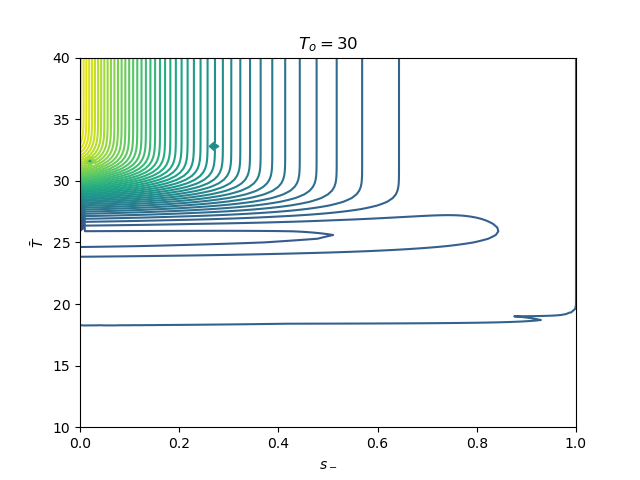

In [65]:
fig, ax = plt.subplots(1, 1)
ax.contour(X, Y, Z,levels=70)
  
ax.set_title(rf"$T_o={To}$")
ax.set_xlabel(r"$s_-$")
ax.set_ylabel(r"$\bar T$")
plt.savefig("contour1.jpeg",dpi=640,bbox_inches='tight')
  
plt.show()

In [46]:
from mpl_toolkits import mplot3d
from matplotlib import cm
%matplotlib notebook

<IPython.core.display.Javascript object>


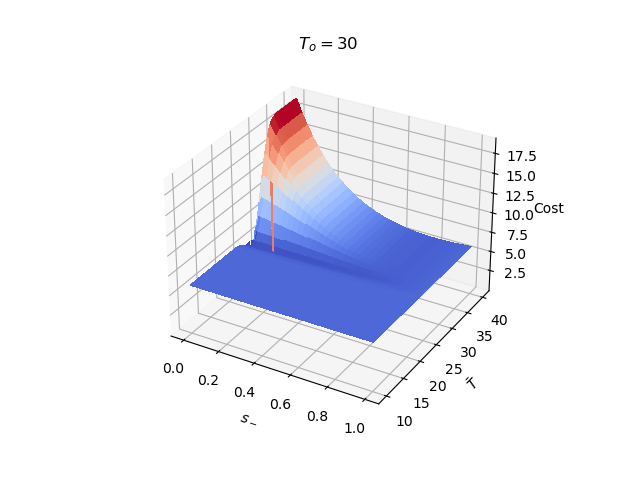

In [64]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel(r"$s_-$")
ax.set_ylabel(r"$\bar T$")
ax.set_zlabel("Cost")
ax.set_title(rf"$T_o={To}$")
plt.savefig("3D_1.jpeg",dpi=640)

plt.show()

### Variety of To

In [8]:
s_plus = 1
alpha = 1
N = 1
Tc = 24
beta = 1
To = 30
Ts = 20
muBar = 0.5
cp = 1
r = 2
c = 15
D = 10

In [9]:
tbarDom = np.linspace(10,40,101)
s_minus_DOM = np.linspace(0,1,101)

In [45]:
from matplotlib import cm
import pickle as p
from mpl_toolkits import mplot3d
%matplotlib inline

In [85]:
X, Y = np.meshgrid(s_minus_DOM,tbarDom)
for To in [20,22,24,26,28,30,32]:
# for To in [20]:
    def f_contour(s_minus,Tbar):
        s = lambda T: s_minus if T <= Tbar else s_plus
        Lcomf = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts) * (T-Tc)**2
        Lpower = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts)*s(T)
        val = alpha*N/2 * quad(Lcomf,-np.inf,np.inf)[0] + beta*(To-Ts)*muBar*N*quad(Lpower,-np.inf,np.inf)[0]
        return val
    f_contour = np.vectorize(f_contour,otypes=[np.ndarray])
    Zvals = f_contour(X,Y)
    fig, ax = plt.subplots(1, 1)
    ax.contour(X, Y, Zvals,levels=70)

    ax.set_title(rf"$T_o={To}$")
    ax.set_xlabel(r"$s_-$")
    ax.set_ylabel(r"$\bar T$")
    plt.savefig(f"contour_{To}.jpeg",dpi=640)
    plt.clf()
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, Zvals, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_xlabel(r"$s_-$")
    ax.set_ylabel(r"$\bar T$")
    ax.set_zlabel("Cost")
    ax.set_title(rf"$T_o={To}$")
    plt.savefig(f"3D_{To}.jpeg",dpi=640)
    plt.clf()
    with open(f"To_{To}.p", "wb") as output_file:
        p.dump(Zvals, output_file)

/var/folders/9b/1dwkfds10dl4580bcnh9j15w0000gn/T/ipykernel_15182/2430234931.py:8: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  val = alpha*N/2 * quad(Lcomf,-np.inf,np.inf)[0] + beta*(To-Ts)*muBar*N*quad(Lpower,-np.inf,np.inf)[0]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [160]:
To = 30
Zvals = np.load(f"To_{To}.p",allow_pickle=True).astype(np.float64)

In [161]:
X, Y = np.meshgrid(s_minus_DOM,tbarDom)
# Zvals = f_contour(X,Y)

In [162]:
fig, ax = plt.subplots(1, 1)
ax.contour(X, Y, Zvals,levels=30)

ax.set_title(rf"$T_o={To}$")
ax.set_xlabel(r"$s_-$")
ax.set_ylabel(r"$\bar T$")
plt.savefig(f"contour_{To}.jpeg",dpi=640)
plt.show()

<IPython.core.display.Javascript object>

In [163]:
%matplotlib notebook

In [164]:
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Zvals, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel(r"$s_-$")
ax.set_ylabel(r"$\bar T$")
ax.set_zlabel("Cost")
ax.set_title(rf"$T_o={To}$")
plt.savefig(f"3D_{To}.jpeg",dpi=640)
plt.show()

<IPython.core.display.Javascript object>

### To with different $\alpha$ and $\beta$

In [168]:
s_plus = 1
alpha = 1
N = 1
Tc = 24
beta = 1
To = 30
Ts = 20
muBar = 0.5
cp = 1
r = 2
c = 15
D = 10

In [169]:
tbarDom = np.linspace(10,40,101)
s_minus_DOM = np.linspace(0,1,101)

/Users/aaronlarsen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


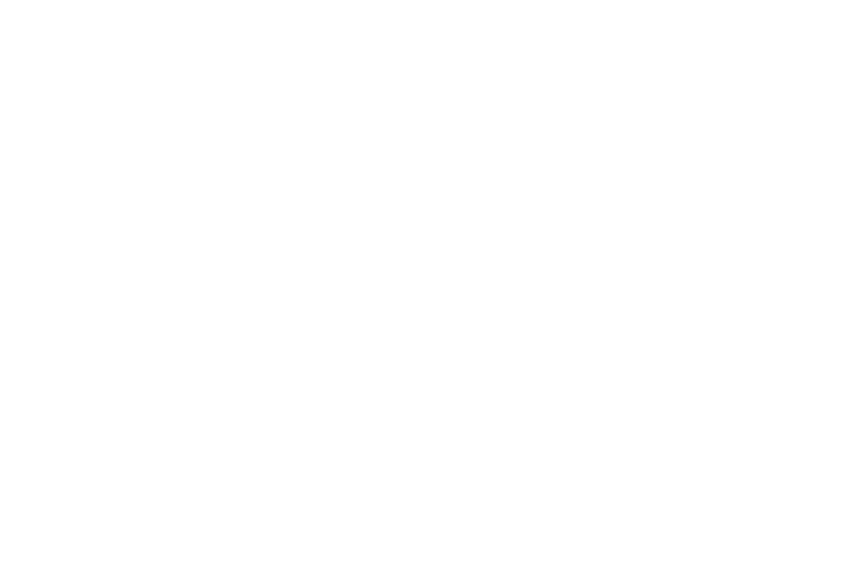

<IPython.core.display.Javascript object>


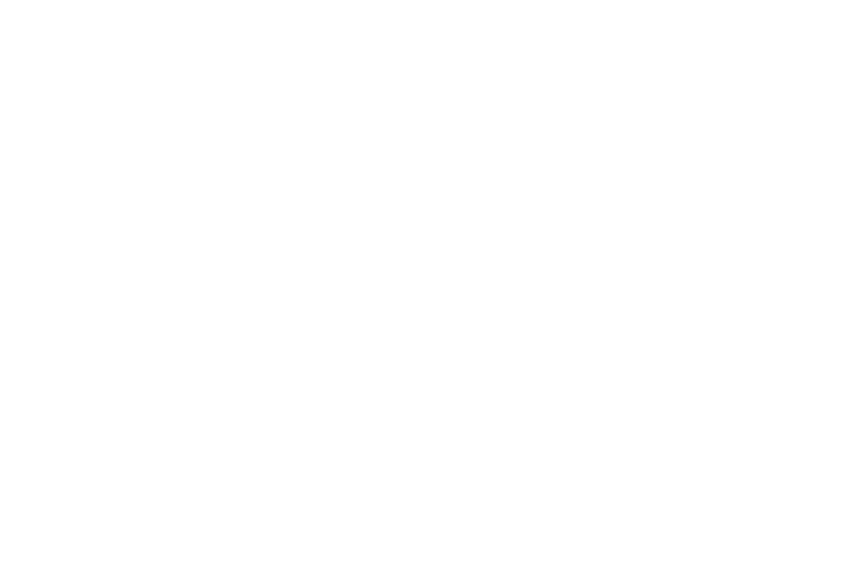

<IPython.core.display.Javascript object>


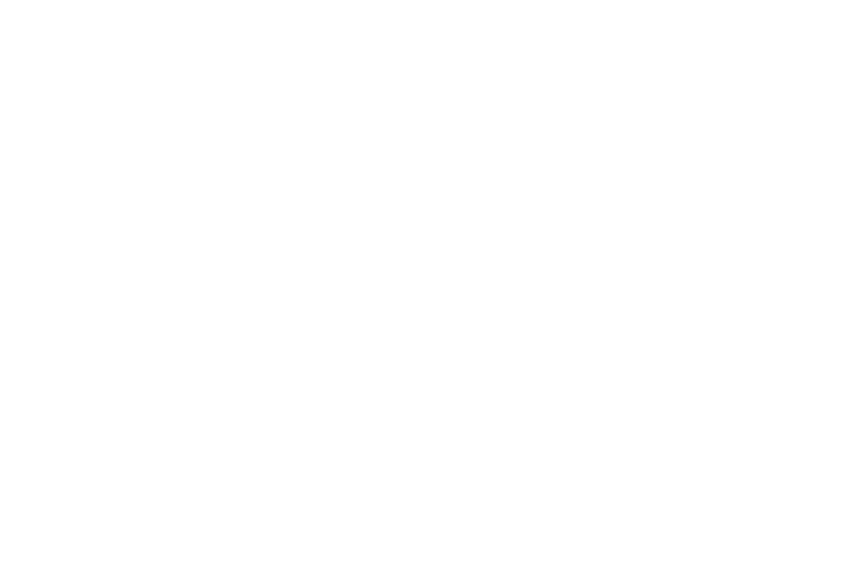

<IPython.core.display.Javascript object>


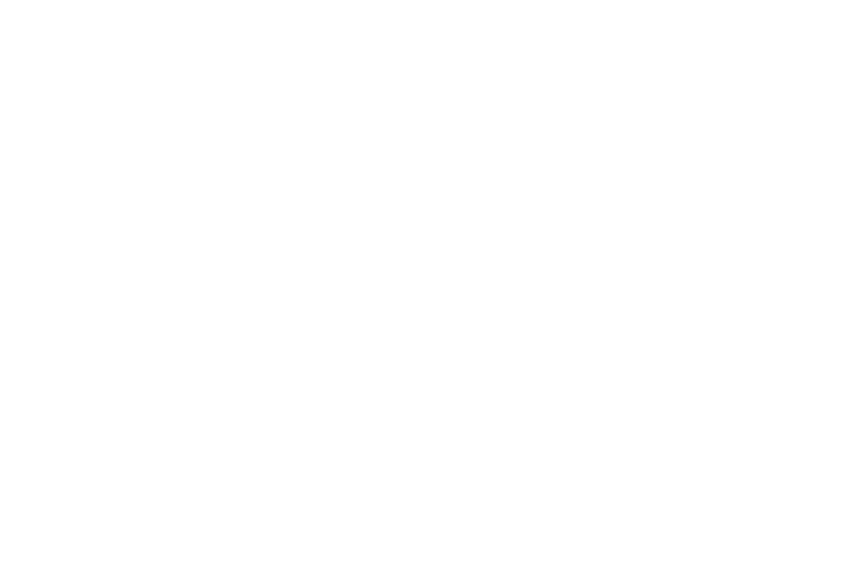

<IPython.core.display.Javascript object>


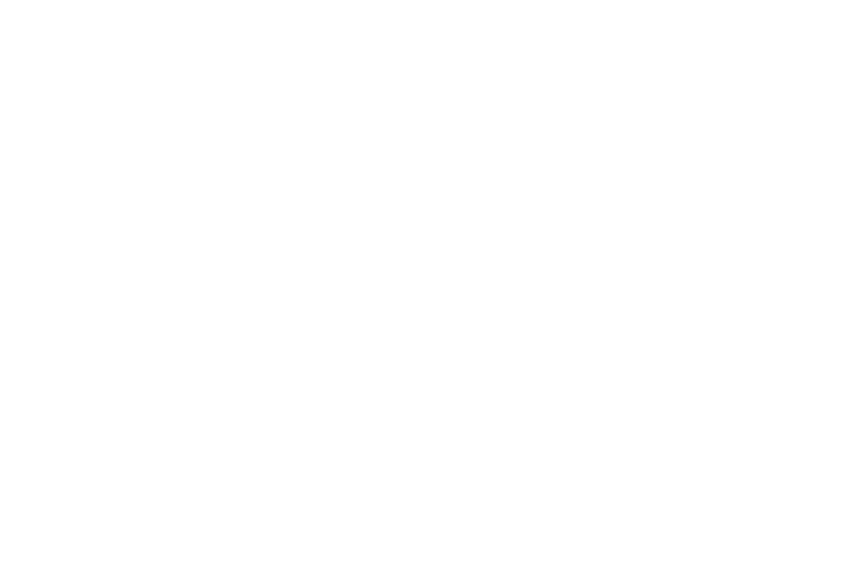

<IPython.core.display.Javascript object>


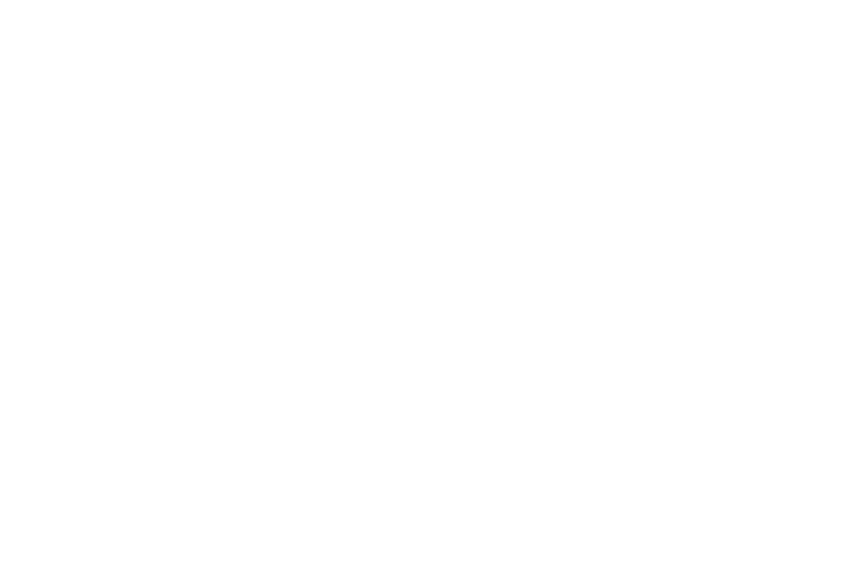

<IPython.core.display.Javascript object>


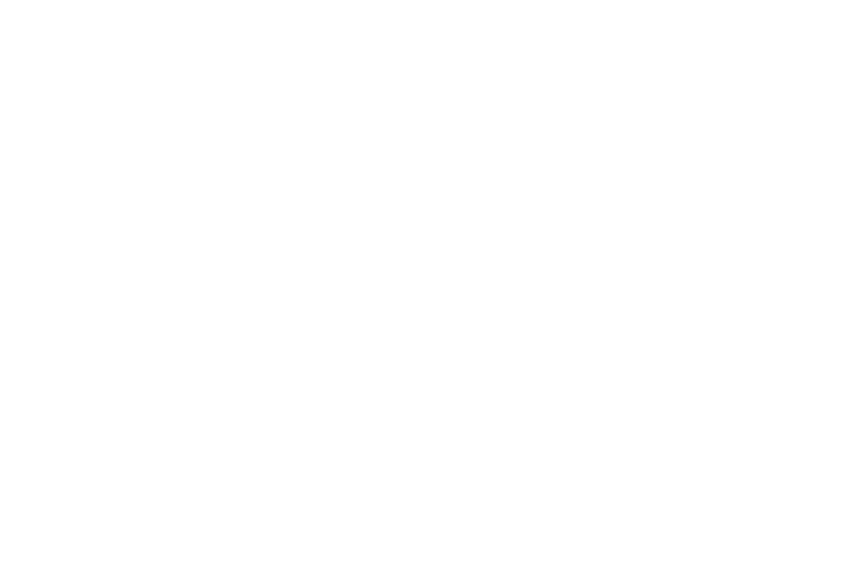

<IPython.core.display.Javascript object>


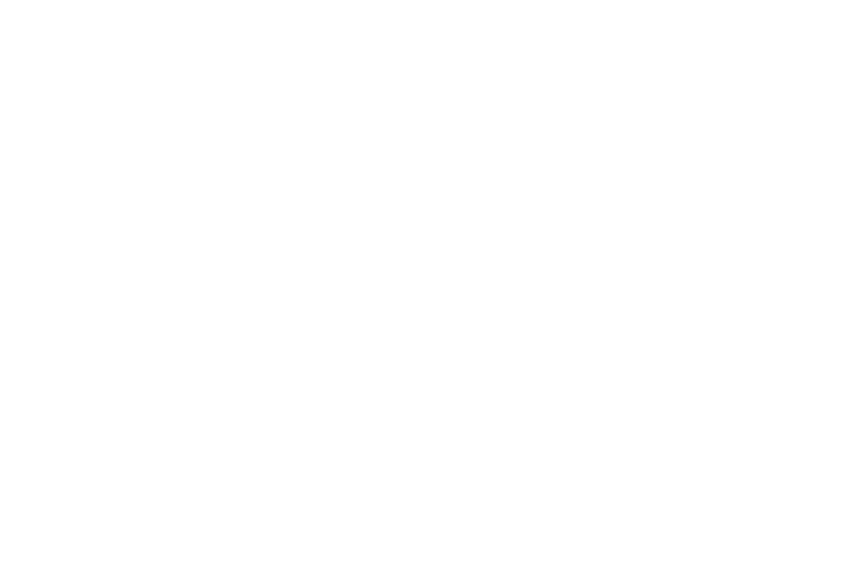

In [173]:
X, Y = np.meshgrid(s_minus_DOM,tbarDom)
To = 24
# for To in [20]:
for alpha,beta in zip([1,0.5,1,0.5],[1,.5,0.5,1]):
    def f_contour(s_minus,Tbar):
        s = lambda T: s_minus if T <= Tbar else s_plus
        Lcomf = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts) * (T-Tc)**2
        Lpower = lambda T: get_P(alpha, T, To, r, muBar, Tbar, s_min=s_minus, s_max=s_plus, Ts=Ts)*s(T)
        val = alpha*N/2 * quad(Lcomf,-np.inf,np.inf)[0] + beta*(To-Ts)*muBar*N*quad(Lpower,-np.inf,np.inf)[0]
        return val
    f_contour = np.vectorize(f_contour,otypes=[np.ndarray])
    Zvals = f_contour(X,Y).astype(np.float64)
    fig, ax = plt.subplots(1, 1)
    ax.contour(X, Y, Zvals,levels=70)

    ax.set_title(rf"$\alpha={alpha}\ \beta={beta}$")
    ax.set_xlabel(r"$s_-$")
    ax.set_ylabel(r"$\bar T$")
    plt.savefig(f"contour_{alpha}_{beta}.jpeg",dpi=640)
    plt.clf()
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, Zvals, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_xlabel(r"$s_-$")
    ax.set_ylabel(r"$\bar T$")
    ax.set_zlabel("Cost")
    ax.set_title(rf"$\alpha={alpha}\ \beta={beta}\ T_o={To}$")
    plt.savefig(f"3D_{alpha}_{beta}_{To}.jpeg",dpi=640)
    plt.clf()
    np.save("To_{alpha}_{beta}_{To}.npy",Zvals)